In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
os.chdir(os.path.abspath('..'))

/home/lewaldm/miniforge3/envs/dinov2/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


['fmow_rgb', 'fmow_s2']
ORIGINAL IMAGES
fmow_rgb torch.Size([3, 7227, 7577]) tensor(0.) tensor(1.)


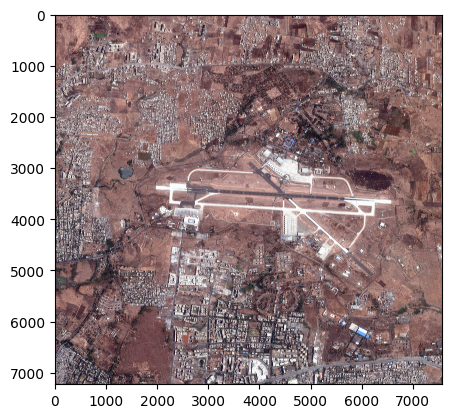

fmow_s2 torch.Size([13, 478, 501]) tensor(0.) tensor(1.)


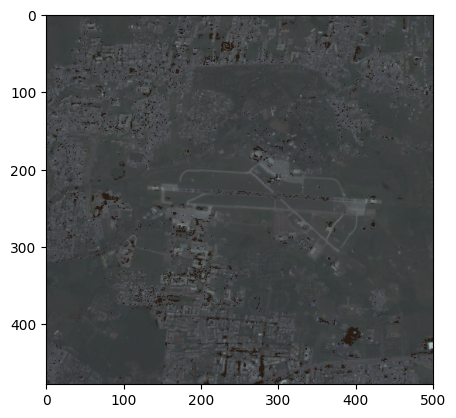

CROPPED IMAGES
fmow_rgb torch.Size([3, 128, 128]) tensor(0.) tensor(1.)
fmow_s2 torch.Size([13, 128, 128]) tensor(0.) tensor(1.)


/home/lewaldm/miniforge3/envs/dinov2/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


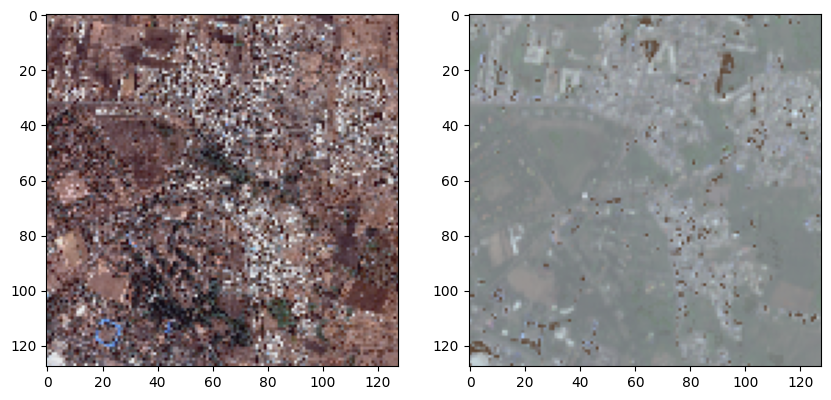

CROPPED IMAGES
fmow_rgb torch.Size([3, 128, 128]) tensor(0.) tensor(1.)
fmow_s2 torch.Size([13, 128, 128]) tensor(0.) tensor(1.)


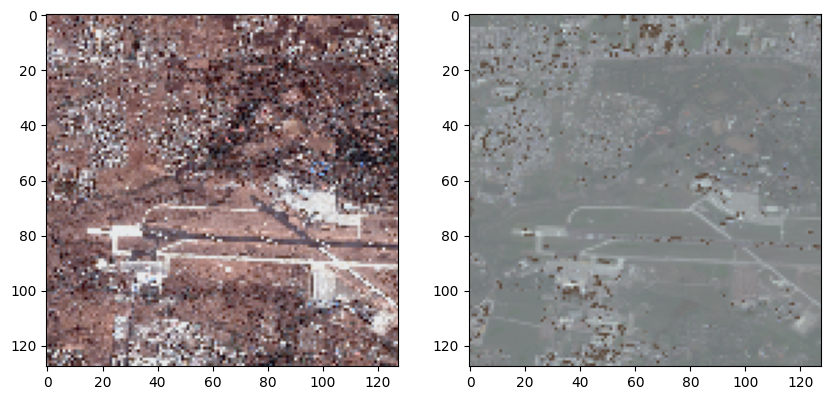

CROPPED IMAGES
fmow_rgb torch.Size([3, 128, 128]) tensor(0.) tensor(1.)
fmow_s2 torch.Size([13, 128, 128]) tensor(0.) tensor(1.)


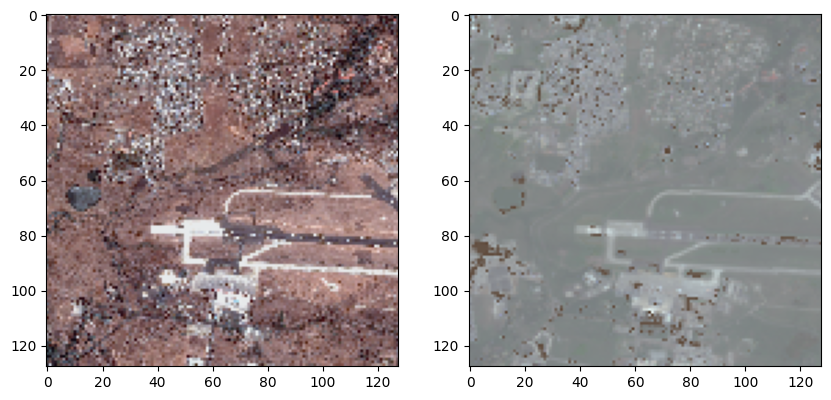

CROPPED IMAGES
fmow_rgb torch.Size([3, 128, 128]) tensor(0.) tensor(1.)
fmow_s2 torch.Size([13, 128, 128]) tensor(0.) tensor(1.)


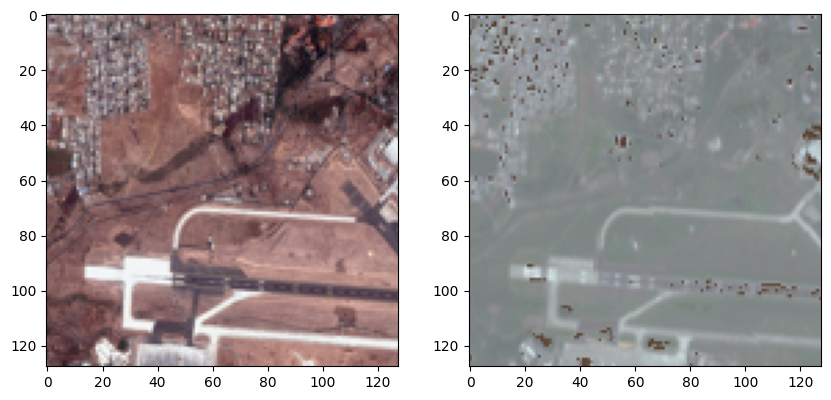

CROPPED IMAGES
fmow_rgb torch.Size([3, 128, 128]) tensor(0.) tensor(1.)
fmow_s2 torch.Size([13, 128, 128]) tensor(0.) tensor(1.)


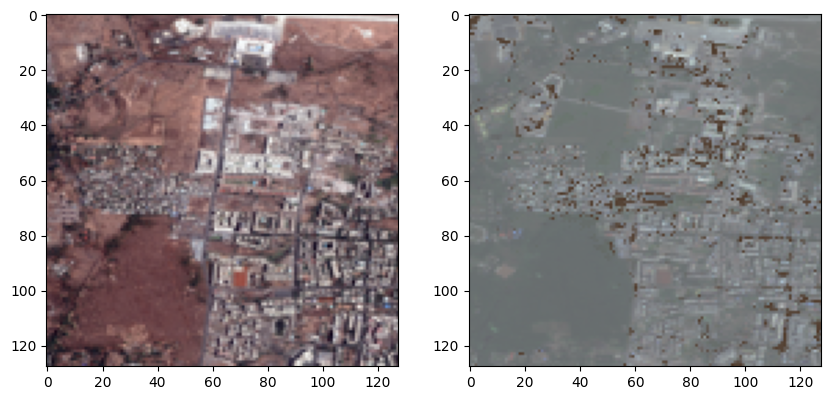

CROPPED IMAGES
fmow_rgb torch.Size([3, 128, 128]) tensor(0.) tensor(1.)
fmow_s2 torch.Size([13, 128, 128]) tensor(0.) tensor(1.)


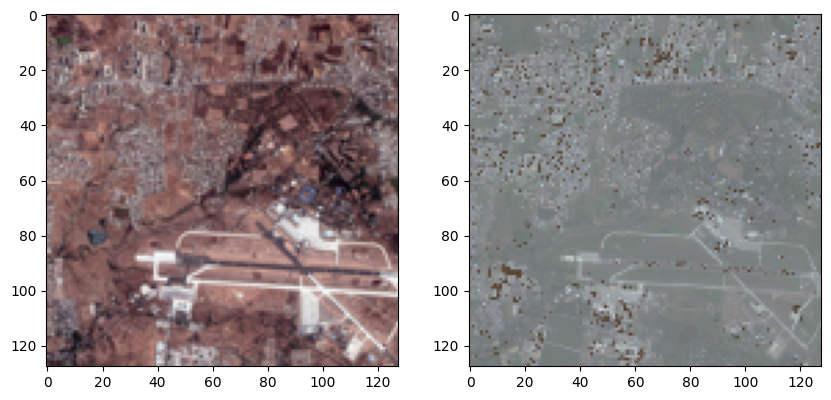

In [12]:
import matplotlib.pyplot as plt
from dinov2.data.datasets.fmow import FmowDataset
from dinov2.data.augmentations import *
from copy import deepcopy

ds = FmowDataset('/data/panopticon/datasets/', 'fmow/metadata_v2/fmow_iwm_onid_val.parquet')

# find image with both rgb and s2
i = 0
while True:
    out = ds[i]
    i += 1
    if set(out['ds_names']) == set(['fmow_s2', 'fmow_rgb']):
        break


def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

def plotimg(img, sensor, size=None, addtitle=''):
    # for fmow
    if sensor in ['fmow_rgb', 'rgbqbwv']:
        img = img[(0,1,2),...]
    elif sensor == 'fmow_s2':
        img = img[(3,2,1),...]
    elif sensor == 'fmow_wv23':
        img = img[(0,1,2),...]

    if size:
        img = torch.functional.F.interpolate(img.unsqueeze(0), size=(size,size), mode='bilinear', align_corners=False).squeeze(0)
        title += f' ({size})'
    plt.imshow(img.permute(1,2,0))

img_list = [ normalize(img) for img in out['imgs'] ]
nchns = [img.shape[0] for img in img_list]
ds_names = out['ds_names']
print(ds_names)

print('ORIGINAL IMAGES')
for i in range(2):
    print(ds_names[i], img_list[i].shape, img_list[i].min(), img_list[i].max())
    plotimg(img_list[i], ds_names[i])
    plt.show()

scale = [0.05,0.5]
for _ in range(3):
    print('CROPPED IMAGES')
    img_crop = ListRandomResizeCrop(128, scale, antialias=False)(img_list)
    start, end = 0, 0
    plt.subplots(1,2, figsize=(10,5))
    for i in range(2):
        start, end = end, end + nchns[i]
        img = normalize(img_crop[start:end])
        print(ds_names[i], img.shape, img.min(), img.max())
        plt.subplot(1,2,i+1)
        plotimg(img, ds_names[i])
    plt.show()

for _ in range(3):
    print('CROPPED IMAGES')
    img_crop = ListRandomResizeCrop(128, scale, antialias=True)(img_list)
    start, end = 0, 0
    plt.subplots(1,2, figsize=(10,5))
    for i in range(2):
        start, end = end, end + nchns[i]
        img = normalize(img_crop[start:end])
        print(ds_names[i], img.shape, img.min(), img.max())
        plt.subplot(1,2,i+1)
        plotimg(img, ds_names[i])
    plt.show()


In [11]:
""" debug chn emb"""
import torch
from dinov2.models.panopticon import ChnEmb
from torch.optim import Adam

chnemb = ChnEmb(8)
optim = Adam(chnemb.parameters(), lr=1.)

optim.zero_grad()

embs = chnemb(torch.tensor([3,20,50, 7]))
embs = embs * torch.tensor([1,2,3,4]).reshape(-1,1)

embs.sum().backward()
optim.step()
print(chnemb.learnable_embs)
print(chnemb.cached_optical_embs)

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]],
       requires_grad=True)
tensor([[ 0.9129,  0.9093,  0.1987,  0.0200,  0.4081, -0.4161,  0.9801,  0.9998],
        [-0.2624, -0.9589,  0.4794,  0.0500,  0.9650,  0.2837,  0.8776,  0.9988]])


In [2]:
""" benchmark vanilla pytorch to torch multihead attention"""

from dinov2.models.panopticon import QueryCrossAttention
import timeit
import torch

device = 'cuda:0'
dim = 128
num_heads = 8
bsz = 190

ours = QueryCrossAttention(dim, num_heads)
current = torch.nn.MultiheadAttention(dim, num_heads, batch_first=True) 
ours.to(device)
current.to(device)

q = torch.randn(bsz, 196, dim, device=device)
kv = torch.randn(bsz, 196, dim, device=device)

# warmup

(timeit.timeit(lambda: ours(q, kv), number=100))
(timeit.timeit(lambda: current(q, kv, kv), number=100))

key_padding_mask = torch.randint(0, 2, (bsz, 196), device=device).bool()
(timeit.timeit(lambda: ours(q, kv, key_padding_mask), number=100))
(timeit.timeit(lambda: current(q, kv, kv, key_padding_mask), number=100))

# actual benchmarking

print('No padding')
print('vanilla:', timeit.timeit(lambda: ours(q, kv), number=100))
print('torch.nn:',timeit.timeit(lambda: current(q, kv, kv), number=100))

print('With padding')
key_padding_mask = torch.randint(0, 2, (bsz, 196), device=device).bool()
print('vanilla:',timeit.timeit(lambda: ours(q, kv, key_padding_mask), number=100))
print('torch.nn:',timeit.timeit(lambda: current(q, kv, kv, key_padding_mask), number=100))


/home/lewaldm/code/PanOpticOn/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/lewaldm/code/PanOpticOn/dinov2/layers/attention.py:28: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/lewaldm/code/PanOpticOn/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


No padding
vanilla: 0.21002019569277763
torch.nn: 0.2726119109429419
With padding
vanilla: 0.29605886805802584
torch.nn: 0.4053810127079487
